# 1-Layer SW Jet Stability in Firdrake #

Weak Form:

\begin{align*}
c \int_A \left[ \phi \hat u + \psi  \hat v + \varphi \hat \eta \right] \, dA
& = \int_A \left( \overline u  \phi  - \frac{1}{Ro k^2} \psi  
+ \frac{1}{Ro} \overline h \varphi  \right)  \hat u \, dA \\
& = \int_A \left( (\partial_y \overline u - \frac{1}{Ro}) \phi  +  \overline u \psi  - \frac{1}{Ro} \overline h \partial_y  \varphi  \right) \hat v \, dA \\
& = \int_A \left( \frac{1}{Ro} \phi - \frac{1}{Ro k^2} \psi \partial_y  + \varphi \overline u   \right) \hat \eta \, dA \\
\end{align*}

In [1]:
# Import Libraries

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from firedrake import *
from firedrake.petsc import PETSc
try:
    from slepc4py import SLEPc
except ImportError:
    import sys
    warning("Unable to import SLEPc, eigenvalue computation not possible (try firedrake-update --slepc)")
    sys.exit(0)

In [2]:
# Define an Interval Mesh

Ly   = 10.0
Uj   = 0.5
n0   = 200
mesh = IntervalMesh(n0, Ly)
x = SpatialCoordinate(mesh)

# Define parameters

beta = Constant('0.0')
Bu   = Constant('0.0004')
Ro   = Constant('0.25')
# Profile

profile = 'bickley'
#profile = 'gaussian'
#profile = 'bump'

In [3]:
print('Ro      = ', float(Ro))
print('Bu      = ', float(Bu))
print('profile = ', profile)

('Ro      = ', 0.25)
('Bu      = ', 0.0004)
('profile = ', 'bickley')


In [4]:
# Order of the Method

p = 0 # Define CG function space

# Function Spaces
V  = FunctionSpace(mesh,'CG',p+2)
Z  = V*V*V

# Impose zero Dirichlet BCs
bc = DirichletBC(Z.sub(1), 0.0, "on_boundary")

# Define modes 

emodes_real, emodes_imag = Function(V), Function(V)

In [5]:
# TEST/TRIAL FUNCTIONS
(u, v, eta)      = TrialFunctions(Z)
(phi, psi, vphi) = TestFunctions(Z)

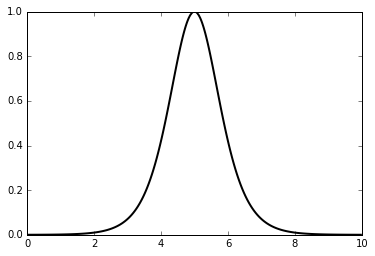

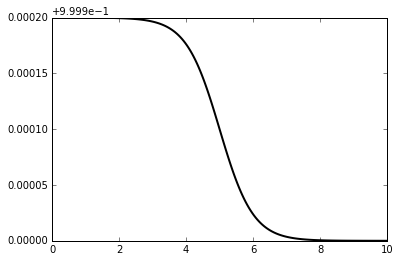

In [6]:
# Define Basic State

#FJP: Do we need Eb or can we remove it?
Ub  = Function(V).interpolate(1./pow(cosh(x[0]-Ly/2),2))
dUb = Function(V).interpolate(1./pow(cosh(x[0]-Ly/2),2))    # FJP: compute correctly
Eb  = Function(V).interpolate(-tanh(x[0]-Ly/2))             # FJP: remove?
Hb  = Function(V).interpolate(1. + Ro*Bu*Eb)

plot(Ub)
plt.show()
plot(Hb)
plt.show()

\begin{align*}
c \int_A \left[ \phi \hat u + \psi  \hat v + \varphi \hat \eta \right] \, dA
& = \int_A \left( \overline u  \phi  - \frac{1}{Ro k^2} \psi  
+ \frac{1}{Ro} \overline h \varphi  \right)  \hat u \, dA \\
& = \int_A \left( (\partial_y \overline u - \frac{1}{Ro}) \phi  +  \overline u \psi  - \frac{1}{Ro} \overline h \partial_y  \varphi  \right) \hat v \, dA \\
& = \int_A \left( \frac{1}{Ro} \phi - \frac{1}{Ro k^2} \psi \partial_y  + \varphi \overline u   \right) \hat \eta \, dA \\
\end{align*}

In [8]:
num_eigenvalues = 4

# Wavenumber
dk   = 1.0
kk   = np.arange(dk, 2.0, dk)
kL   = len(kk)
egs_re  = np.zeros((len(kk),num_eigenvalues))
egs_im  = np.zeros((len(kk),num_eigenvalues))

cnt = 0
for k in kk:

    k2   = Constant(k**2)

    # Define Weak form
    
    a =   ( (Ub*phi             - 1./(Ro*k2)*psi          + 1./Ro*Hb*vphi)*u )*dx \
        + ( ((dUb - psi/Ro)*phi + Ub*psi                  - 1./Ro*Hb*vphi.dx(0))*v )*dx \
        + ( 1./Ro*phi*eta       - 1./(Ro*k2)*psi*eta.dx(0) + vphi*Ub )*dx
    m = (phi*u + psi*v + vphi*eta)*dx
    
    # Build Petsc operators
    
    petsc_a = assemble(a, mat_type='aij', bcs=bc).M.handle
    petsc_m = assemble(m, mat_type='aij', bcs=bc).M.handle

    # Define Petsc options

    opts = PETSc.Options()
    opts.setValue("eps_gen_non_hermitian", None)
    opts.setValue("st_pc_factor_shift_type", "NONZERO")
    #opts.setValue("eps_type", "lapack")
    opts.setValue("eps_type", "krylovschur")
    opts.setValue("eps_largest_imaginary", None)
    opts.setValue("eps_tol", 1e-10)

    # Define Solver options

    es = SLEPc.EPS().create(comm=COMM_WORLD)
    es.setDimensions(num_eigenvalues)
    es.setOperators(petsc_a, petsc_m)
    es.setFromOptions()
    es.solve()

    # Additionally we can find the number of converged eigenvalues. ::

    nconv = es.getConverged()
    imax = min(nconv, num_eigenvalues)
    for i in range(imax):
        vr, vi = petsc_a.getVecs()

        lam = es.getEigenpair(i, vr, vi)
        
        egs_re[cnt,i] = k*lam.real
        egs_im[cnt,i] = k*lam.imag
    
    # Find eigenfunctions
    #emodes_real.vector()[:], emodes_imag.vector()[:] = vr, vi
    #print "Leading eigenvalue is:", lam, " for cnt = ", cnt, " with nconv = ", nconv
    
    cnt += 1
    
print np.max(abs(egs_im))

ArityMismatch: Adding expressions with non-matching form arguments (Argument(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7f695114f390>, FiniteElement('Lagrange', interval, 2), name=None), Mesh(VectorElement(FiniteElement('Lagrange', interval, 1), dim=1), 1)), 0, None), Argument(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7f695114f390>, FiniteElement('Lagrange', interval, 2), name=None), Mesh(VectorElement(FiniteElement('Lagrange', interval, 1), dim=1), 1)), 1, None)) vs (Argument(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7f695114f390>, FiniteElement('Lagrange', interval, 2), name=None), Mesh(VectorElement(FiniteElement('Lagrange', interval, 1), dim=1), 1)), 0, None),).